# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [63]:
# Import your libraries:

%matplotlib inline
import re
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [64]:
pd.set_option("display.max_columns", None)

In [65]:
websites = pd.read_csv('../website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [66]:
websites.head()


,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,NaN,NaN,10/10/2015 18:21,NaN,7,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,NaN,NaN,NaN,NaN,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,NaN,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0


In [67]:
websites.info()
'''WHOIS_UPDATED_DATE 1642 non-null   object => if needed for furhter analysis then first should be transform to datetype'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1781 non-null   object 
 1   URL_LENGTH                 1781 non-null   int64  
 2   NUMBER_SPECIAL_CHARACTERS  1781 non-null   int64  
 3   CHARSET                    1774 non-null   object 
 4   SERVER                     1605 non-null   object 
 5   CONTENT_LENGTH             969 non-null    float64
 6   WHOIS_COUNTRY              1475 non-null   object 
 7   WHOIS_STATEPRO             1419 non-null   object 
 8   WHOIS_REGDATE              1654 non-null   object 
 9   WHOIS_UPDATED_DATE         1642 non-null   object 
 10  TCP_CONVERSATION_EXCHANGE  1781 non-null   int64  
 11  DIST_REMOTE_TCP_PORT       1781 non-null   int64  
 12  REMOTE_IPS                 1781 non-null   int64  
 13  APP_BYTES                  1781 non-null   int64

'WHOIS_UPDATED_DATE 1642 non-null   object => if needed for furhter analysis then first should be transform to datetype'

In [68]:
websites.shape

(1781, 21)

In [69]:
websites.isna().sum()
'''WHOIS_UPDATED_DATE 812 NaN out of 1781 values => must be taken in account if needed for further analysis, if dropped we 
could loose too many data to get a good model.
WHOIS_COUNTRY (306 NaN) WHOIS_STATEPRO (362 NaN) SERVER (176 NaN) WHOIS_UPDATED_DATE (139 NaN) WHOIS_REGDATE (127 NaN) 
also should be taken into account if needed. If dropped still have enough data in these last columns.'''

'WHOIS_UPDATED_DATE 812 NaN out of 1781 values => must be taken in account if needed for further analysis, if dropped we \ncould loose too many data to get a good model.\nWHOIS_COUNTRY (306 NaN) WHOIS_STATEPRO (362 NaN) SERVER (176 NaN) WHOIS_UPDATED_DATE (139 NaN) WHOIS_REGDATE (127 NaN) \nalso should be taken into account if needed. If dropped still have enough data in these last columns.'

In [70]:
'''WE assum that Type column is the target and that 0 means "no malicious" and 1 means "malicious" this column as well 
as the others with string values are not going to be considered for the correlation matrix 
'''

'WE assum that Type column is the target and that 0 means "no malicious" and 1 means "malicious" this column as well \nas the others with string values are not going to be considered for the correlation matrix \n'

#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [71]:
websites.sample()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
1725,M4_59,124,24,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,0,0,0,0,0,2,124,0,0,0.0,1


In [72]:
corr_df = websites[['URL_LENGTH','NUMBER_SPECIAL_CHARACTERS','CONTENT_LENGTH','TCP_CONVERSATION_EXCHANGE','DIST_REMOTE_TCP_PORT','REMOTE_IPS','APP_BYTES','SOURCE_APP_PACKETS','REMOTE_APP_PACKETS','SOURCE_APP_BYTES','REMOTE_APP_BYTES','APP_PACKETS','DNS_QUERY_TIMES']].corr()
corr_df

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES
URL_LENGTH,1.000000,0.917986,0.129745,-0.038407,-0.039839,-0.046367,-0.026446,-0.042264,-0.033779,-0.014857,-0.026686,-0.042264,-0.068582
NUMBER_SPECIAL_CHARACTERS,0.917986,1.000000,0.214225,-0.037459,-0.042619,-0.047103,-0.023914,-0.040096,-0.030597,-0.014376,-0.024098,-0.040096,-0.050048
CONTENT_LENGTH,0.129745,0.214225,1.000000,0.078451,-0.000381,0.004774,0.051202,0.074142,0.091077,0.100094,0.047595,0.074142,-0.045644
TCP_CONVERSATION_EXCHANGE,-0.038407,-0.037459,0.078451,1.000000,0.555188,0.331080,0.457320,0.997796,0.990848,0.865580,0.458702,0.997796,0.349832
DIST_REMOTE_TCP_PORT,-0.039839,-0.042619,-0.000381,0.555188,1.000000,0.210188,0.780238,0.558612,0.591188,0.313359,0.781212,0.558612,0.259942
REMOTE_IPS,-0.046367,-0.047103,0.004774,0.331080,0.210188,1.000000,0.023126,0.361104,0.304683,0.171651,0.025324,0.361104,0.548189
APP_BYTES,-0.026446,-0.023914,0.051202,0.457320,0.780238,0.023126,1.000000,0.445822,0.468999,0.074464,0.999992,0.445822,0.012221
SOURCE_APP_PACKETS,-0.042264,-0.040096,0.074142,0.997796,0.558612,0.361104,0.445822,1.000000,0.989285,0.857495,0.447448,1.000000,0.410843
REMOTE_APP_PACKETS,-0.033779,-0.030597,0.091077,0.990848,0.591188,0.304683,0.468999,0.989285,1.000000,0.880555,0.470401,0.989285,0.355716
SOURCE_APP_BYTES,-0.014857,-0.014376,0.100094,0.865580,0.313359,0.171651,0.074464,0.857495,0.880555,1.000000,0.075328,0.857495,0.215285


<Axes: >

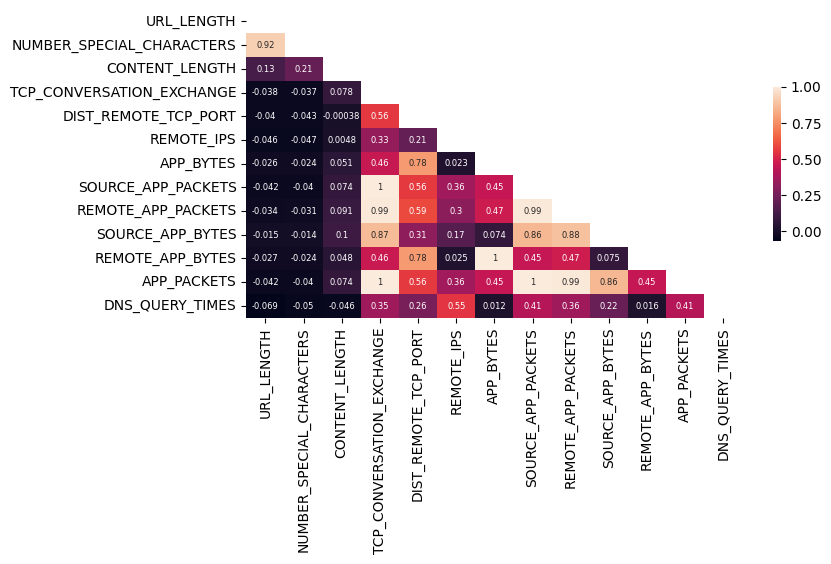

In [73]:
plt.figure(figsize=(8,4))
mask = np.triu(np.ones_like(corr_df), k=0)
sns.heatmap(corr_df,annot=True, mask = mask,
            vmax=1,
            cbar_kws={"shrink": .5},
           annot_kws={"size": 6})

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

<Axes: >

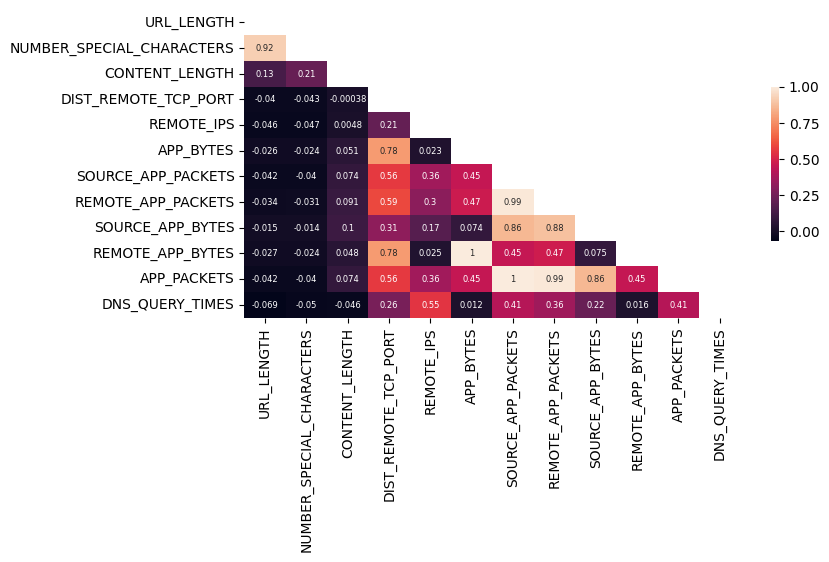

In [74]:
'''as TCP_CONVERSATION_EXCHANGE is the one that has the highest number of 1 in the correlation matrix with other columns we will drop 
it and check again for correlations. We will follow this steps until no correlations are deteced'''
websit_uncorr=websites.drop(columns='TCP_CONVERSATION_EXCHANGE')
corr_df = websit_uncorr[['URL_LENGTH','NUMBER_SPECIAL_CHARACTERS','CONTENT_LENGTH','DIST_REMOTE_TCP_PORT','REMOTE_IPS','APP_BYTES','SOURCE_APP_PACKETS','REMOTE_APP_PACKETS','SOURCE_APP_BYTES','REMOTE_APP_BYTES','APP_PACKETS','DNS_QUERY_TIMES']].corr()
plt.figure(figsize=(8,4))
mask = np.triu(np.ones_like(corr_df), k=0)
sns.heatmap(corr_df,annot=True, mask = mask,
            vmax=1,
            cbar_kws={"shrink": .5},
           annot_kws={"size": 6})

<Axes: >

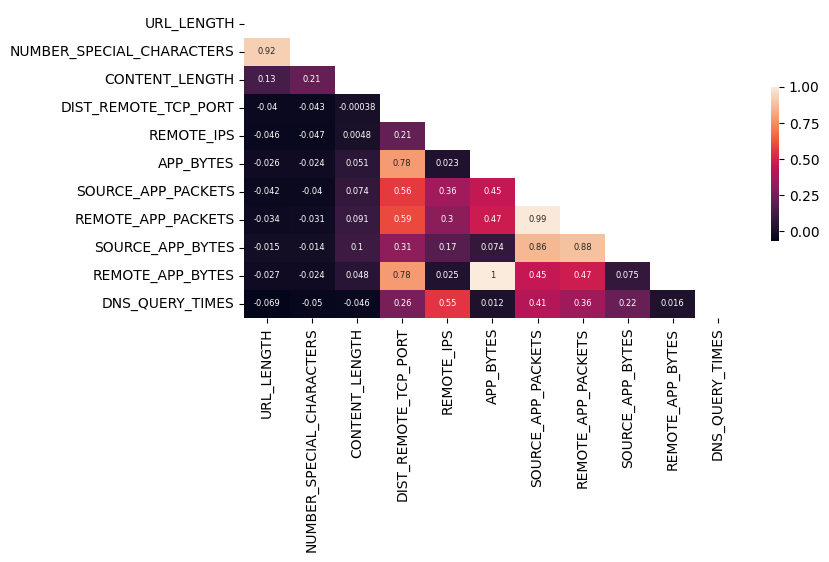

In [75]:
'''the next with the highest number of correlations is APP_PACKETS so now we will drop this one '''
websit_uncorr=websites.drop(columns='APP_PACKETS')
corr_df = websit_uncorr[['URL_LENGTH','NUMBER_SPECIAL_CHARACTERS','CONTENT_LENGTH','DIST_REMOTE_TCP_PORT','REMOTE_IPS','APP_BYTES','SOURCE_APP_PACKETS','REMOTE_APP_PACKETS','SOURCE_APP_BYTES','REMOTE_APP_BYTES','DNS_QUERY_TIMES']].corr()
plt.figure(figsize=(8,4))
mask = np.triu(np.ones_like(corr_df), k=0)
sns.heatmap(corr_df,annot=True, mask = mask,
            vmax=1,
            cbar_kws={"shrink": .5},
           annot_kws={"size": 6})

<Axes: >

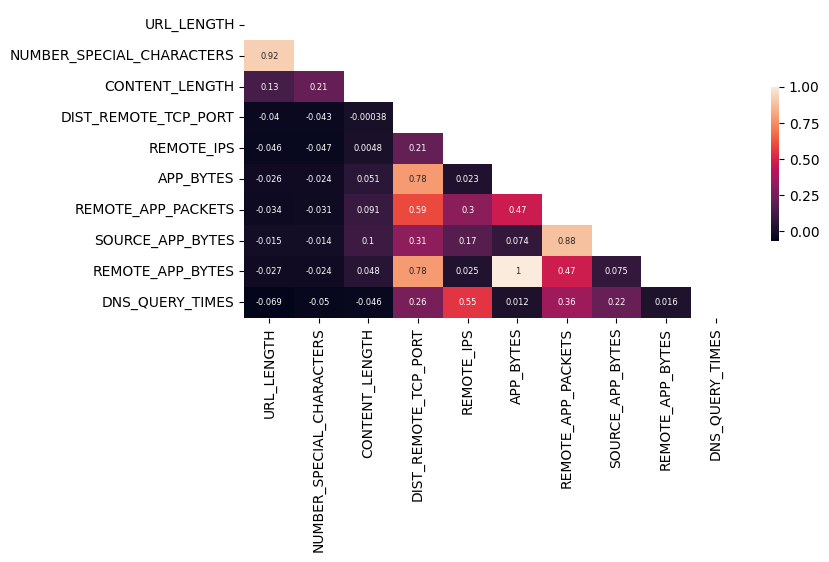

In [76]:
'''finally we will drop SOURCE_APP_PACKETS as, from the two that still have two high correlation is the one with the highest
correlation value although below 0.9'''
websit_uncorr=websites.drop(columns='SOURCE_APP_PACKETS')
corr_df = websit_uncorr[['URL_LENGTH','NUMBER_SPECIAL_CHARACTERS','CONTENT_LENGTH','DIST_REMOTE_TCP_PORT','REMOTE_IPS','APP_BYTES','REMOTE_APP_PACKETS','SOURCE_APP_BYTES','REMOTE_APP_BYTES','DNS_QUERY_TIMES']].corr()
plt.figure(figsize=(8,4))
mask = np.triu(np.ones_like(corr_df), k=0)
sns.heatmap(corr_df,annot=True, mask = mask,
            vmax=1,
            cbar_kws={"shrink": .5},
           annot_kws={"size": 6})


<Axes: >

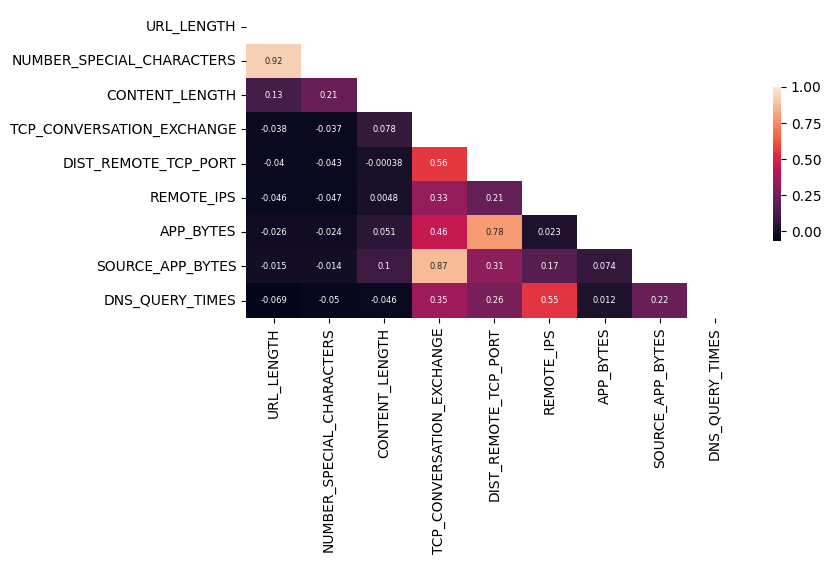

In [77]:
'''still there is a column with high correlation REMOTE_APP_BYTES, so we will dropt his column too '''
websit_uncorr=websites.drop(columns='REMOTE_APP_BYTES')
corr_df = websit_uncorr[['URL_LENGTH','NUMBER_SPECIAL_CHARACTERS','CONTENT_LENGTH','TCP_CONVERSATION_EXCHANGE','DIST_REMOTE_TCP_PORT','REMOTE_IPS','APP_BYTES','SOURCE_APP_BYTES','DNS_QUERY_TIMES']].corr()
plt.figure(figsize=(8,4))
mask = np.triu(np.ones_like(corr_df), k=0)
sns.heatmap(corr_df,annot=True, mask = mask,
            vmax=1,
            cbar_kws={"shrink": .5},
           annot_kws={"size": 6})

In [78]:
'''finally we will drop the columns we have detected with the correlaton in the original dataframe'''
websites = websites.drop(columns=['REMOTE_APP_BYTES','TCP_CONVERSATION_EXCHANGE','APP_PACKETS','SOURCE_APP_PACKETS'])

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [79]:
websites.isna().sum()

URL                            0
URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        7
SERVER                       176
CONTENT_LENGTH               812
WHOIS_COUNTRY                306
WHOIS_STATEPRO               362
WHOIS_REGDATE                127
WHOIS_UPDATED_DATE           139
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [80]:
'''as detected in the Challenge 1, column CONTENT_LENGTH has more than half of its values NaN so we drop it'''
websites = websites.drop(columns='CONTENT_LENGTH')

In [81]:
websites.isna().sum()

URL                            0
URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        7
SERVER                       176
WHOIS_COUNTRY                306
WHOIS_STATEPRO               362
WHOIS_REGDATE                127
WHOIS_UPDATED_DATE           139
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

In [82]:
'''now we drop rows with NaN values'''
websites.dropna(inplace = True)
websites.shape

(1257, 16)

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [83]:

websites.isna().sum() # all looks fine!

URL                          0
URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [84]:
websites.WHOIS_COUNTRY.unique()

array(['US', 'SC', 'RU', 'AU', 'CA', 'PA', 'IN', 'GB', "[u'GB'; u'UK']",
       'NL', 'UG', 'JP', 'CN', 'UK', 'SI', 'ru', 'KY', 'AT', 'CZ', 'PH',
       'LV', 'TR', 'ES', 'us', 'HK', 'UA', 'CH', 'BS', 'PK', 'IL', 'DE',
       'SE', 'IT', 'NO', 'BE', 'BY', 'AE', 'IE', 'UY', 'KG'], dtype=object)

In [85]:
websites['WHOIS_COUNTRY']= websites['WHOIS_COUNTRY'].str.upper()
websites['WHOIS_COUNTRY']= websites['WHOIS_COUNTRY'].str.replace("[U'GB'; U'GB']",'GB').str.replace('UK','GB')
websites.WHOIS_COUNTRY.unique()

array(['US', 'SC', 'RU', 'AU', 'CA', 'PA', 'IN', 'GB', "[U'GB'; U'GB']",
       'NL', 'UG', 'JP', 'CN', 'SI', 'KY', 'AT', 'CZ', 'PH', 'LV', 'TR',
       'ES', 'HK', 'UA', 'CH', 'BS', 'PK', 'IL', 'DE', 'SE', 'IT', 'NO',
       'BE', 'BY', 'AE', 'IE', 'UY', 'KG'], dtype=object)

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

In [86]:
websites.WHOIS_COUNTRY.value_counts()

WHOIS_COUNTRY
US                960
CA                 75
ES                 63
AU                 26
PA                 21
GB                 17
JP                 10
CZ                  8
CN                  8
IN                  8
RU                  6
NL                  5
[U'GB'; U'GB']      5
CH                  5
BS                  4
AT                  4
KY                  3
PH                  3
SC                  3
UA                  2
UY                  2
KG                  2
HK                  2
SI                  2
TR                  1
PK                  1
IL                  1
DE                  1
SE                  1
IT                  1
NO                  1
BE                  1
BY                  1
AE                  1
IE                  1
UG                  1
LV                  1
Name: count, dtype: int64

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [87]:
top_ten=websites.WHOIS_COUNTRY.value_counts().head(10)
websites['WHOIS_COUNTRY']= websites['WHOIS_COUNTRY'].apply(lambda x: x if x in top_ten else "OTHER")
websites.WHOIS_COUNTRY.value_counts()

WHOIS_COUNTRY
US       960
CA        75
ES        63
OTHER     61
AU        26
PA        21
GB        17
JP        10
IN         8
CN         8
CZ         8
Name: count, dtype: int64

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [88]:
websites.drop(columns = ['WHOIS_COUNTRY','WHOIS_STATEPRO','WHOIS_REGDATE','WHOIS_UPDATED_DATE'], inplace = True)

In [89]:
websites.sample()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type
1267,B0_754,63,10,UTF-8,ATS,10,7,4825,36,37575,10.0,0


# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [90]:
websites.dtypes


URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [91]:
websites.drop(columns = 'URL', inplace = True)

#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [92]:
websites.CHARSET.unique()

array(['ISO-8859-1', 'UTF-8', 'iso-8859-1', 'us-ascii', 'utf-8',
       'windows-1251', 'windows-1252'], dtype=object)

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [93]:
websites.SERVER.unique()

array(['nginx', 'Apache/2', 'Microsoft-HTTPAPI/2.0', 'Apache',
       'openresty/1.11.2.1', 'Apache/2.4.7 (Ubuntu)', 'nginx/1.12.0',
       'Apache/2.4.12 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'cloudflare-nginx', 'Apache/2.2.22', 'nginx/1.8.0',
       'Apache/2.2.29 (Amazon)', 'Microsoft-IIS/7.5',
       'Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'Apache/2.2.22 (Debian)', 'Apache/2.2.15 (CentOS)',
       'Apache/2.4.25 (Amazon) PHP/7.0.14', 'GSE',
       'Apache/2.4.23 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Pepyaka/1.11.3', 'Apache/2.4.25 (Amazon) OpenSSL/1.0.1k-fips',
       'Apache/2.2.22 (Ubuntu)', 'Apache/2.4.25', 'Tengine',
       'Apache/2.4.18 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Apache/2.4.6 (CentOS) PHP/5.6.8', 'AmazonS3',
       'Apache/1.3.37 (Unix) mod_perl/1.29 mod_ssl/2.8.28 OpenSSL/0.9.7e-p1',
       'ATS', 'CherryPy/3.6.0', 'Apache/2.2.15 (Red Hat)', 'Server',
       'Apache/2.4.6 (C

In [94]:
websites.SERVER.value_counts().head(10)

SERVER
Apache                   311
nginx                    144
cloudflare-nginx          80
Microsoft-HTTPAPI/2.0     76
GSE                       49
Server                    48
Microsoft-IIS/7.5         42
YouTubeFrontEnd           41
nginx/1.12.0              31
ATS                       30
Name: count, dtype: int64

In [95]:
len(websites.SERVER.value_counts())

193

In [96]:
'''if in countries we have just kept the top 10 the same reasoning could be carried on for SERVER column'''


'if in countries we have just kept the top 10 the same reasoning could be carried on for SERVER column'

![Think Hard](../think-hard.jpg)

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [97]:
websites['SERVER'] = websites['SERVER'].apply(lambda x: 'Microsoft' if 'Microsoft' in x else x)

In [98]:
websites['SERVER'].value_counts()

SERVER
Apache                                                                                311
nginx                                                                                 144
Microsoft                                                                             144
cloudflare-nginx                                                                       80
GSE                                                                                    49
                                                                                     ... 
CherryPy/3.6.0                                                                          1
Apache/2.4.6 (CentOS) OpenSSL/1.0.1e-fips mod_fcgid/2.3.9 PHP/5.4.16 mod_jk/1.2.40      1
mw2199.codfw.wmnet                                                                      1
fbs                                                                                     1
Apache/2.2.16 (Debian)                                                                  1
Nam

In [99]:
servers = ('Microsoft','Apache','nginx')
websites['SERVER'] = websites['SERVER'].apply(lambda x: x if x in servers else 'Other')

In [100]:
websites['SERVER'].value_counts()

SERVER
Other        658
Apache       311
nginx        144
Microsoft    144
Name: count, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)).** Make sure you drop the categorical columns by passing `drop_first=True` to `get_dummies` as we don't need them any more. **Also, assign the data with dummy values to a new variable `website_dummy`.**

In [101]:
website_dummy = pd.get_dummies(websites,drop_first=True)
website_dummy.sample()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type,CHARSET_UTF-8,CHARSET_iso-8859-1,CHARSET_us-ascii,CHARSET_utf-8,CHARSET_windows-1251,CHARSET_windows-1252,SERVER_Microsoft,SERVER_Other,SERVER_nginx
954,52,12,0,0,0,0,0,0.0,0,False,False,False,False,False,False,False,True,False


Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [102]:
website_dummy.info() # all done and looks fine!

<class 'pandas.core.frame.DataFrame'>
Index: 1257 entries, 3 to 1780
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL_LENGTH                 1257 non-null   int64  
 1   NUMBER_SPECIAL_CHARACTERS  1257 non-null   int64  
 2   DIST_REMOTE_TCP_PORT       1257 non-null   int64  
 3   REMOTE_IPS                 1257 non-null   int64  
 4   APP_BYTES                  1257 non-null   int64  
 5   REMOTE_APP_PACKETS         1257 non-null   int64  
 6   SOURCE_APP_BYTES           1257 non-null   int64  
 7   DNS_QUERY_TIMES            1257 non-null   float64
 8   Type                       1257 non-null   int64  
 9   CHARSET_UTF-8              1257 non-null   bool   
 10  CHARSET_iso-8859-1         1257 non-null   bool   
 11  CHARSET_us-ascii           1257 non-null   bool   
 12  CHARSET_utf-8              1257 non-null   bool   
 13  CHARSET_windows-1251       1257 non-null   bool   
 1

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [103]:
from sklearn.model_selection import train_test_split

In [104]:
website_dummy.sample()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type,CHARSET_UTF-8,CHARSET_iso-8859-1,CHARSET_us-ascii,CHARSET_utf-8,CHARSET_windows-1251,CHARSET_windows-1252,SERVER_Microsoft,SERVER_Other,SERVER_nginx
755,46,8,0,2,680,10,1363,4.0,0,True,False,False,False,False,False,False,False,False


In [105]:
X=website_dummy.drop(columns='Type')
y=website_dummy.Type
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [109]:
from sklearn.linear_model import LogisticRegression as LogReg

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [110]:
lr=LogReg(max_iter = 1000)

In [111]:
lr_model = lr.fit(X_train,y_train)

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [112]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [113]:
y_pred = lr_model.predict(X_test)

What are your thoughts on the performance of the model? Write your conclusions below.

In [114]:
confusion_matrix(y_pred, y_test)

array([[226,   7],
       [  9,  10]], dtype=int64)

In [115]:
cf = pd.DataFrame(confusion_matrix(y_test,y_pred))
cf

,0,1
0,226,9
1,7,10


In [116]:
acc=accuracy_score(y_test, y_pred)
acc

0.9365079365079365

In [117]:
'''it has a good accurancy but  number data for type=0 is far higher than for Type = 1 so we are not so good 
predicting malicious webs'''

'it has a good accurancy but  number data for type=0 is far higher than for Type = 1 so we are not so good \npredicting malicious webs'

#### Our second algorithm is is DecisionTreeClassifier

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `DecisionTreeClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where max_depth=3

In [118]:
from sklearn.tree import DecisionTreeClassifier

To test your model, compute the predicted probabilities, decide 0 or 1 using a threshold of 0.5 and print the confusion matrix as well as the accuracy score (on the test set!)

In [54]:
dtc=DecisionTreeClassifier()
dtc_model = dtc.fit(X_train, y_train)
y_tr_pred = dtc_model.predict(X_test)

In [55]:
trcf = pd.DataFrame(confusion_matrix(y_test,y_tr_pred))
trcf

,0,1
0,213,9
1,4,26


In [56]:
tracc=accuracy_score(y_test, y_tr_pred)
tracc

0.9484126984126984

#### We'll create another DecisionTreeClassifier model with max_depth=5. 
Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [119]:
dtc_depth_5=DecisionTreeClassifier(max_depth=5)
dtc_depth_5_model = dtc.fit(X_train, y_train)
y_trdepth_5_pred = dtc_model.predict(X_test)

In [120]:
trcf_depth_5 = pd.DataFrame(confusion_matrix(y_test,y_tr_pred))
trcf_depth_5

,0,1
0,203,32
1,14,3


In [121]:
tracc_depth_5 =accuracy_score(y_test, y_tr_pred)
tracc_depth_5 

0.8174603174603174

Did you see an improvement in the confusion matrix when increasing max_depth to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [58]:
'''no, I see no improvement, just the opposite, we have higher false positives and negatives, also accurancy has decreace 
from 0.948 down to 0.817'''

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [122]:
from sklearn.preprocessing import RobustScaler

In [123]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [124]:
X_test_scaled = scaler.transform(X_test)

In [125]:
lr_model_sk=lr.fit(X_train_scaled,y_train)

In [126]:
y_pred_sk = lr_model_sk.predict(X_test_scaled)

In [127]:
cf_sk = pd.DataFrame(confusion_matrix(y_test,y_pred_sk))
cf_sk

,0,1
0,228,7
1,7,10


In [129]:
acc_sk=accuracy_score(y_test, y_pred_sk)
acc_sk

0.9444444444444444

In [ ]:
'''we have improved the negatives but not the possitives. Nevertheless there is a slight improvement'''